 # GOLUB use case

In [1]:
library("binom") 
library("evaluomeR")
library("cancerclass")
library("dplyr")
library("caret")
library("MLmetrics")
library("ggplot2")
library("ggrepel")
library("reshape2")

options(scipen=10)
options(repr.plot.width=12, repr.plot.height=12)

Cargando paquete requerido: SummarizedExperiment

Cargando paquete requerido: MatrixGenerics

Cargando paquete requerido: matrixStats


Adjuntando el paquete: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles,

# Table of contents
* [Dataset](#dataset)
    * [Top 100](#top)
* [evaluomeR - optimal $k$ analysis](#evaluomeR)
    * [Stability plotting](#evaluomeR_stab_plot)
    * [Quality plotting](#evaluomeR_qual_plot)
* [PCA](#pca)
* [Sensitivity](#sensitivity)
* [CER](#cer)

# Dataset <a class="anchor" id="dataset"></a>

In [2]:
seed = 13606
k.range = c(3,10)
cbi = "clara"
alpha = NULL

In [3]:
data("golub")
golub = golub
colnames(golub)[colnames(golub) == 'Case'] <- 'Description'
head(golub)

,Description,AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,⋯,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at,Class
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,B1,4.16250,3.98847,3.93090,3.82930,3.67274,2.00000,2.00000,2.0000,3.29336,⋯,2.83059,2.00000,3.49914,2.91960,2.30750,3.92536,2.07555,2.23553,3.82595,B
2,T1,2.78888,2.06070,3.18127,3.34537,3.52724,3.04218,3.35545,2.0000,2.29667,⋯,3.40926,3.96624,3.71533,2.00000,2.69810,3.25479,2.00000,3.19535,3.46195,T
3,T2,3.75351,3.51481,3.56443,3.52179,2.00000,2.89321,2.31175,2.0000,2.76268,⋯,2.52763,4.20412,2.85003,3.38364,2.64345,2.00000,2.23553,2.50379,2.00000,T
4,B2,3.68574,3.36040,3.40976,3.48544,2.00432,2.00000,2.00000,2.0000,3.68851,⋯,2.43457,2.00000,2.00000,2.79029,2.98632,3.42911,2.59660,2.37658,3.14364,B
5,B3,3.10857,3.43632,2.49969,3.05308,3.10585,2.00000,2.30750,2.4014,3.52930,⋯,2.56820,2.00000,2.73640,2.45637,2.22272,3.37014,2.09342,3.03383,3.36399,B
6,T3,3.61784,3.43823,3.38093,3.59173,2.00000,2.00000,3.18639,2.0000,2.00000,⋯,2.50651,4.13117,3.25888,2.00000,2.07918,2.00000,2.00000,3.01536,2.00000,T


Three types of classes within the dataset: **B**, **T** and **M**.

In [4]:
level_mapping <- c("B" = 1, "T" = 2, "M" = 3)
map_strings_to_numbers <- function(strings) {
  factorized <- factor(strings, levels = names(level_mapping))
  as.numeric(factorized)
}
gold_standard_vector = as.vector(unlist(lapply(golub["Class"], map_strings_to_numbers)))
gold_standard_vector

[1] 1 2 2 1 1 2 1 1 2 2 2 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3
[39] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3

*Further information regarding GOLUB in [cancerclass](https://rdrr.io/bioc/cancerclass/man/GOLUB.html) package.*

Here, we prepare the GOLUB dataset for the analysis, in order to do so, we remove non-numeric columns:

In [5]:
golub_clean = evaluomeR::cleanDataset(golub, correlation_threshold=1)
pca_suitability = evaluomeR::PCASuitability(golub_clean$R, sig_level = 0.05)
dataset = golub_clean$dataset

if (pca_suitability$pca_suitable) {
    r_pca = evaluomeR::performPCA(dataset = dataset)
    dataset = r_pca$dataset_ncp
    evaluomeR::plotPCA_fviz_screeplot(r_pca$pca)
    evaluomeR::plotPCA_fviz_biplot(r_pca$pca)
}

Preprocessing dataset

Removing non-numeric columns...

	Non-numeric columns found:

		Class

Removing correlations...

	No correlated columns found

Checking PCA suitability...

	PCA is not suitable. Bartlett's test produced NA for p-value.



# evaluomeR - optimal $k$ analysis <a class="anchor" id="evaluomeR"></a>

In this Section, evaluomeR executes an optimal $k$ analysis. First, stabilities and qualities are calculated, considering all the metrics in the dataset. The $k$ range is $k \in [3,10]$ and the clustering method is `rskc`.

In [6]:
r_atsc = evaluomeR::ATSC(data=dataset, k.range=k.range, cbi=cbi, alpha=alpha, 
                         max_alpha=0.2, gold_standard=gold_standard_vector, seed=seed)

Computing optimal k value with 'clara'




Data loaded.
Number of rows: 72
Number of columns: 101



Processing all metrics, 'merge', in dataframe (100)

	Calculation of k = 3

	Calculation of k = 4

	Calculation of k = 5

	Calculation of k = 6

	Calculation of k = 7

	Calculation of k = 8

	Calculation of k = 9

	Calculation of k = 10



Data loaded.
Number of rows: 72
Number of columns: 101



Processing all metrics, 'merge', in dataframe (100)

	Calculation of k = 3

	Calculation of k = 4

	Calculation of k = 5

	Calculation of k = 6

	Calculation of k = 7

	Calculation of k = 8

	Calculation of k = 9

	Calculation of k = 10

Processing metric: all_metrics


	Maximum stability and quality values matches the same K value: '3'


Optimal k: 3

Determining best L1 and alpha parameter automatically, it might take a while...

Computing best L1 boundry with 'sparcl::KMeansSparseCluster.permute'

Best L1 found is: 7.24137931034483, using floor: 7

Running stability and quality indexes with 

In [7]:
print(paste0("Optimal k before: ", r_atsc$optimalK))
print(paste0("Optimal k after: ", r_atsc$optimalK_ATSC))
if (!is.null(r_atsc$gold_standard_trimmed)) {
    print(paste0("Gold standard vector trimmed, current values are:"))
    print(gold_standard_vector)
    print("After:")
    print(r_atsc$gold_standard_trimmed)
    gold_standard_vector = r_atsc$gold_standard_trimmed
}

[1] "Optimal k before: 3"
[1] "Optimal k after: 3"
[1] "Gold standard vector trimmed, current values are:"
 [1] 1 2 2 1 1 2 1 1 2 2 2 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3
[39] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[1] "After:"
 [1] 1 2 1 1 2 1 2 2 2 1 2 1 1 1 1 1 1 2 1 1 1 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3


Automatic computation of $L_1$ bound and $alpha$ accordingot the optimal $k$. The optimal $k$ is retrieved from the `kmeans` analysis in the notebook [golub.ipynb](https://github.com/neobernad/evaluomeR/blob/master/notebooks/use_cases/golub.ipynb). 

## Stability plotting <a class="anchor" id="evaluomeR_stab_plot"></a>

Stability plot

In [8]:
stab = r_atsc$stab
rownames(stab) = c(paste0("stab_", cbi))
stab$Metric = rownames(stab)
stab$Method = cbi
stab_melt = melt(stab, id.vars = c("Metric", "Method"))

stab_ATSC = r_atsc$stab_ATSC
rownames(stab_ATSC) = c(paste0("stab_", "ATSC"))
stab_ATSC$Metric = rownames(stab_ATSC)
stab_ATSC$Method = "ATSC"
stab_ATSC_melt = melt(stab_ATSC, id.vars = c("Metric", "Method"))

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


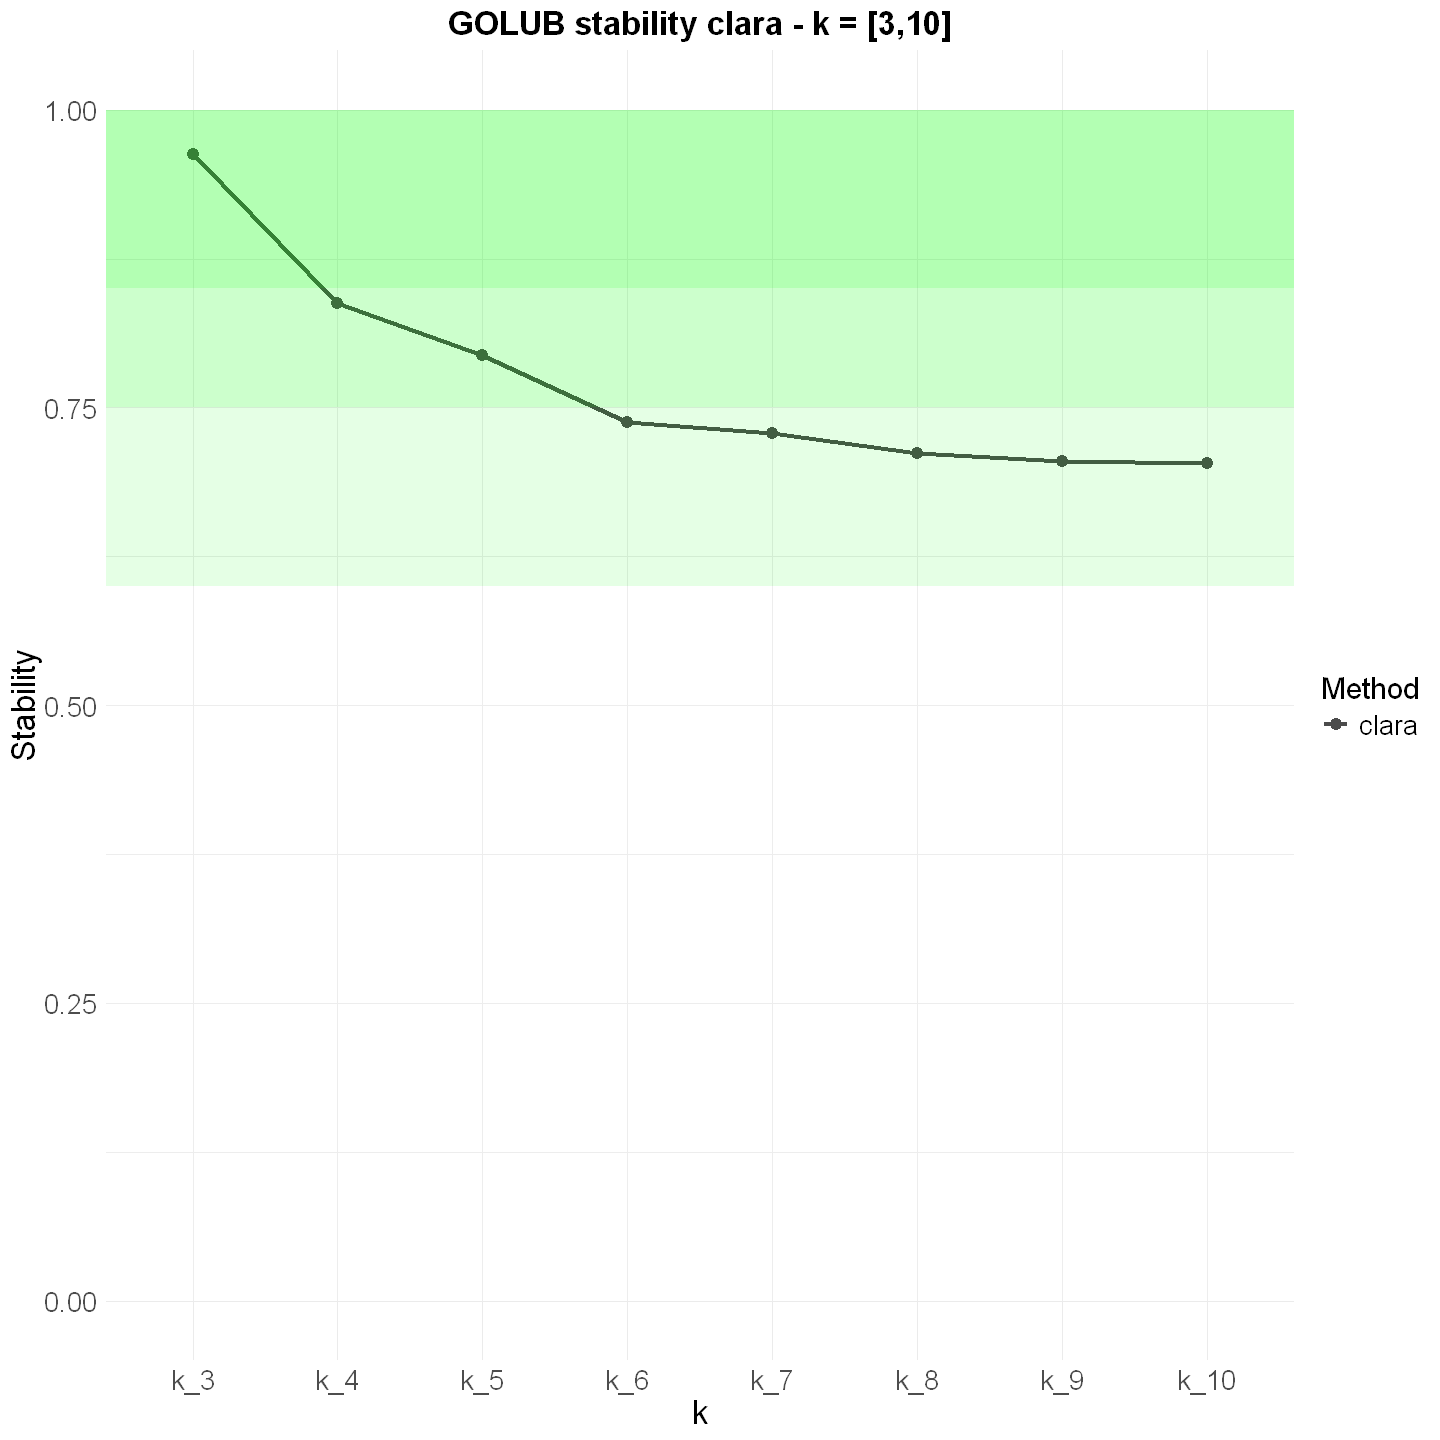

In [9]:
# Color
grayscale_colors <- c("#4B4B4B", "#1E90FF", "black", "darkgray", "gray", "lightgray", "white")

p <- ggplot(stab_melt, aes(x = variable, y = value, color = Method, group = Method)) +
    geom_point(size = 3) +
     geom_line(size = 1.2) +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('GOLUB stability ',cbi,' - k = [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Stability'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16)
  )

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.3, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.2, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.1, fill = "white")

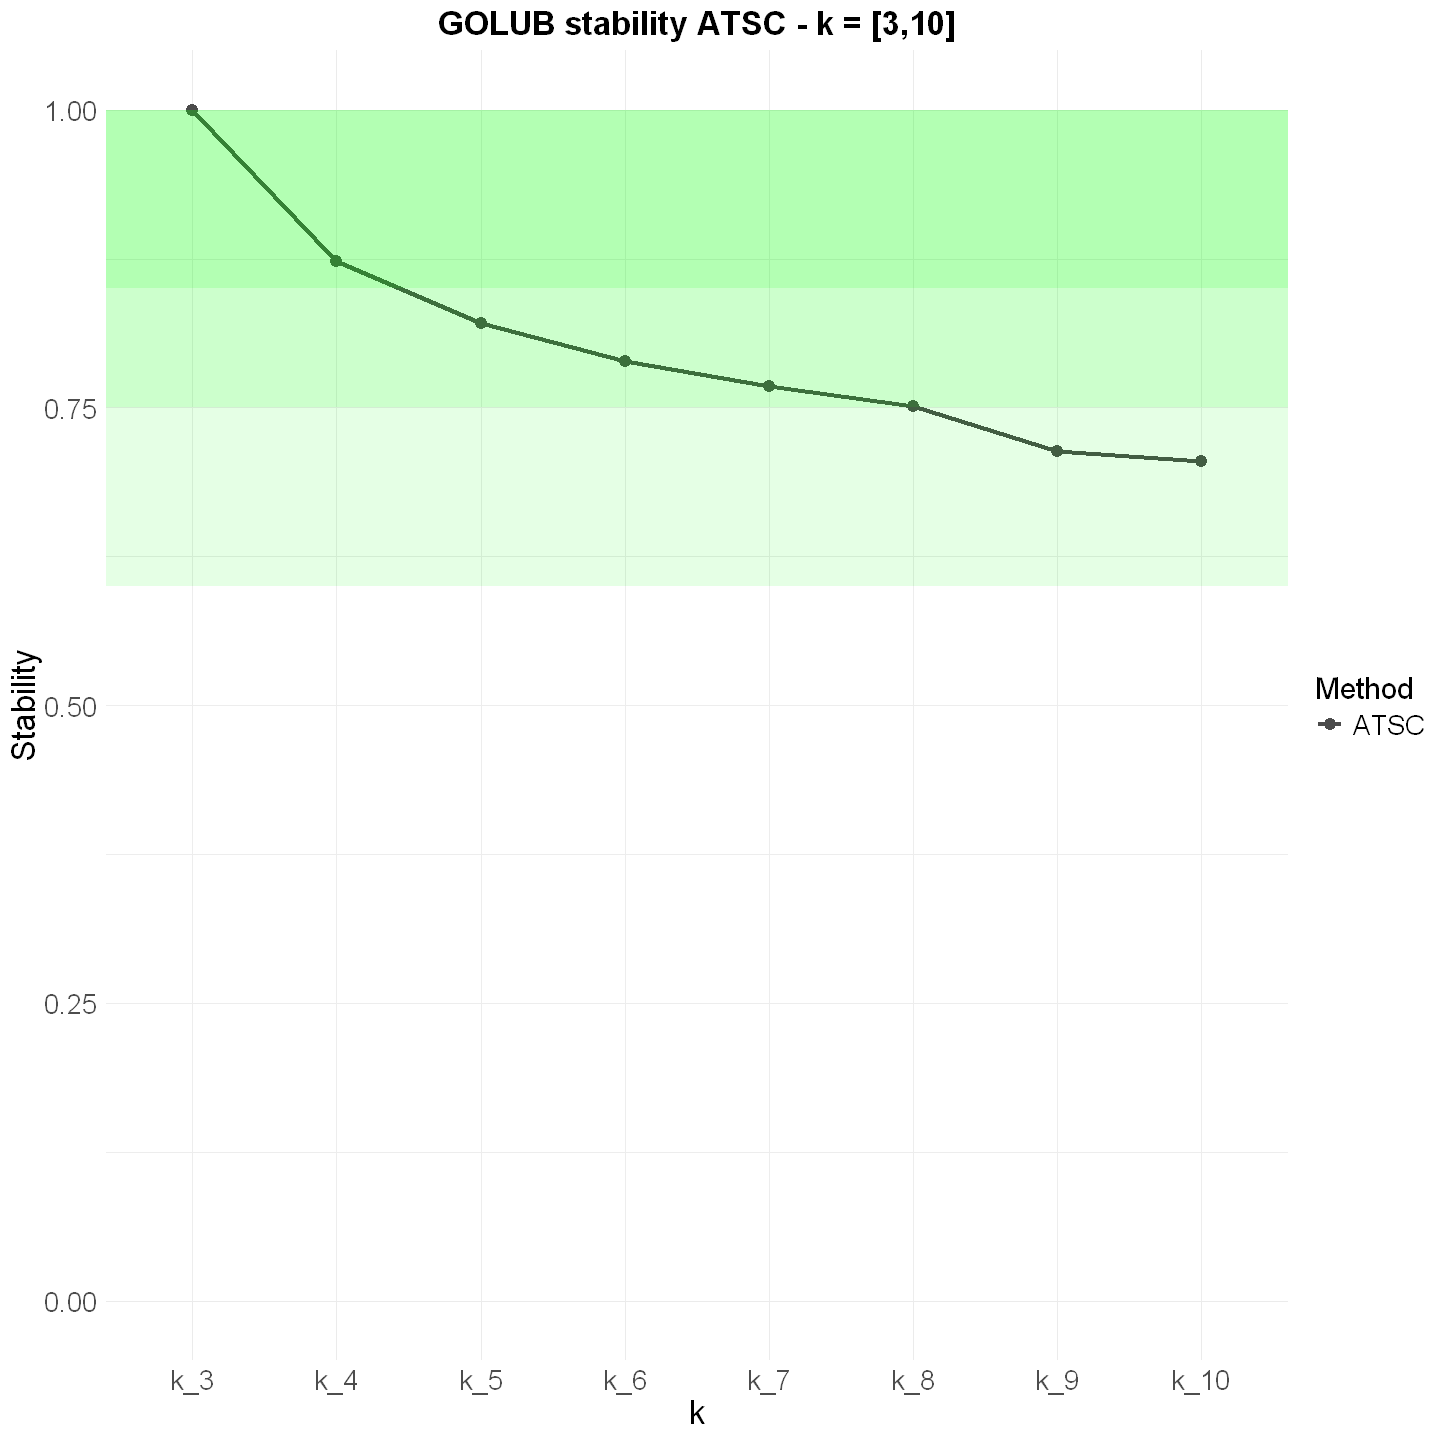

In [10]:
# Stab ATSC
p <- ggplot(stab_ATSC_melt, aes(x = variable, y = value, color = Method, group = Method)) +
    geom_point(size = 3) +
     geom_line(size = 1.2) +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('GOLUB stability ATSC - k = [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Stability'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16)
  )

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.3, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.2, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.1, fill = "white")

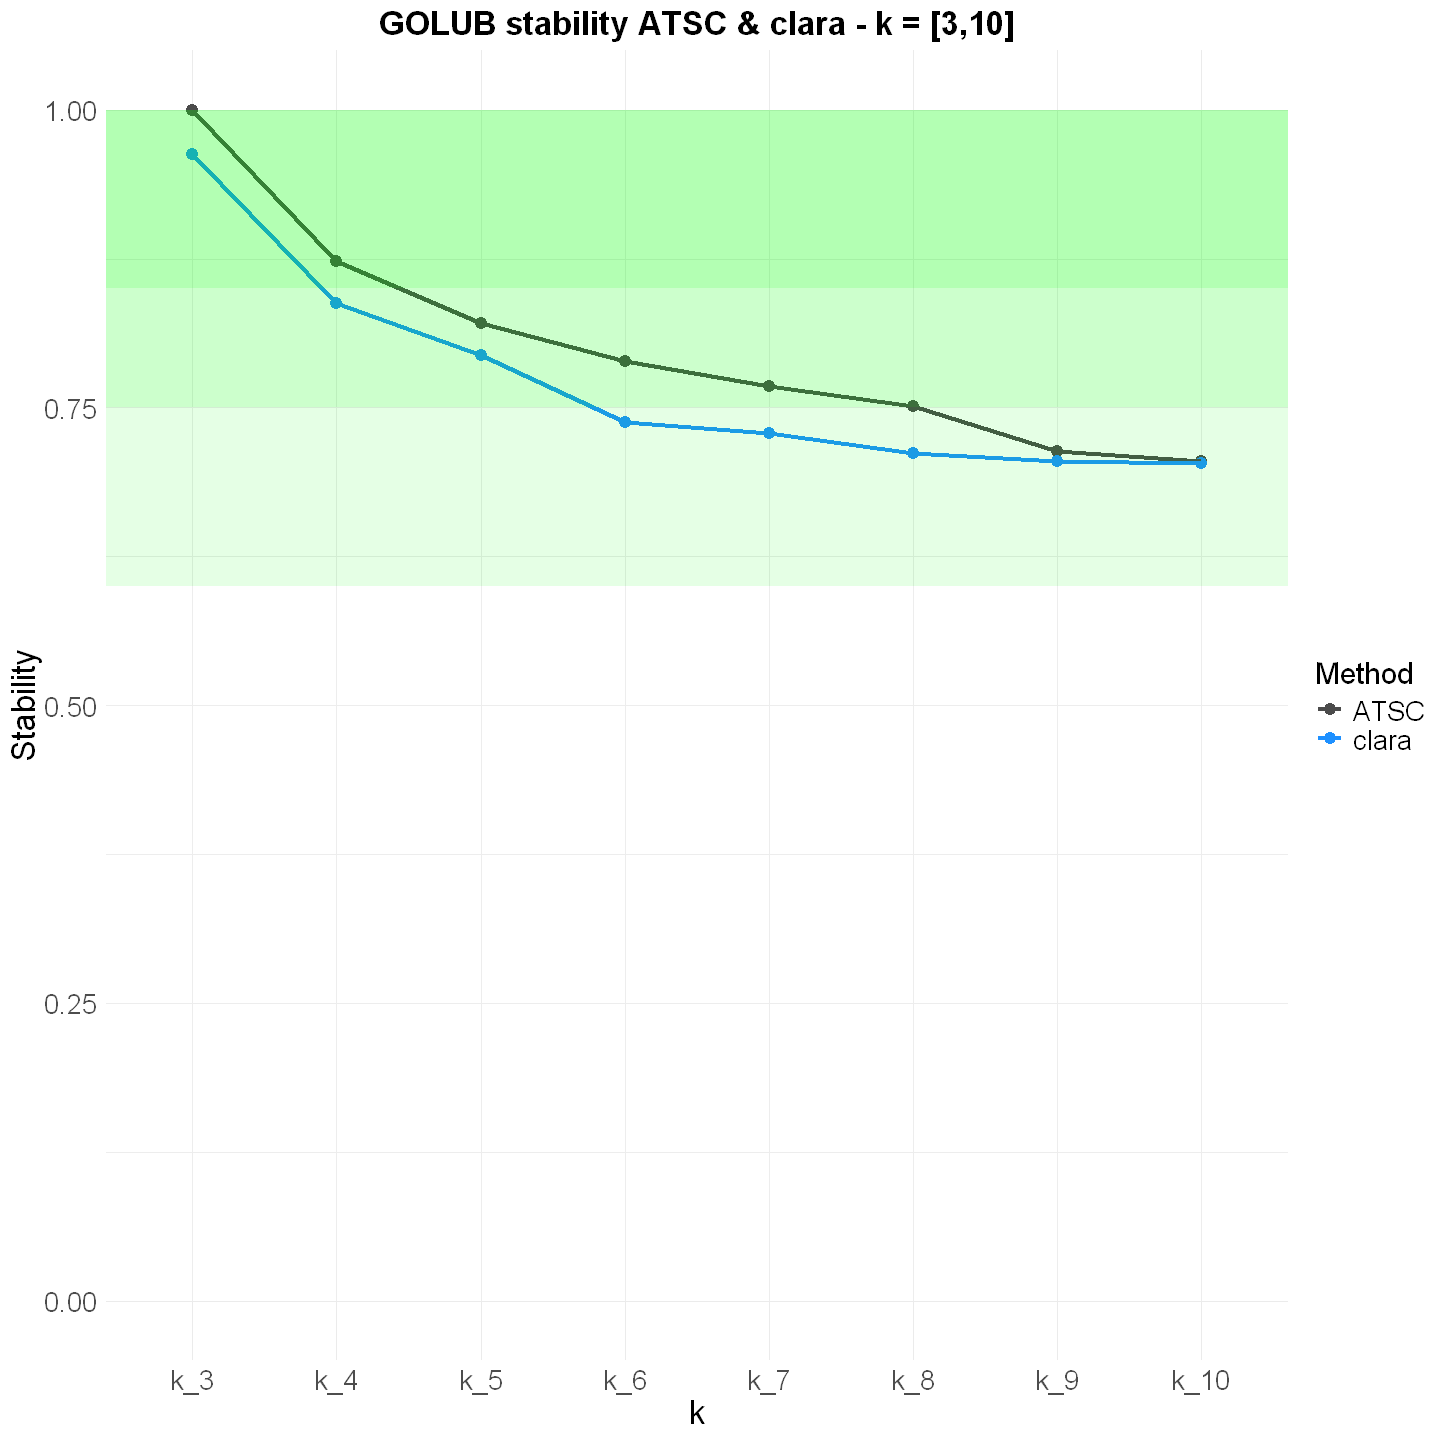

In [11]:
all_stab = rbind(stab_ATSC_melt, stab_melt)
p <- ggplot(all_stab, aes(x = variable, y = value, color = Method, group = Method)) +
    geom_point(size = 3) +
     geom_line(size = 1.2) +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('GOLUB stability ATSC & ', cbi, ' - k = [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Stability'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16)
  )

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.3, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.2, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.1, fill = "white")

Quality calculation with $k \in [3,10]$ and `RSKC`.

## Quality plotting <a class="anchor" id="evaluomeR_qual_plot"></a>

Quality plot

In [12]:
qual = r_atsc$qual
rownames(qual) = c(paste0("qual_", cbi))
qual$Metric = rownames(qual)
qual$Method = cbi
qual_melt = melt(qual, id.vars = c("Metric", "Method"))

qual_ATSC = r_atsc$qual_ATSC
rownames(qual_ATSC) = c(paste0("qual_", "ATSC"))
qual_ATSC$Metric = rownames(qual_ATSC)
qual_ATSC$Method = "ATSC"
qual_ATSC_melt = melt(qual_ATSC, id.vars = c("Metric", "Method"))

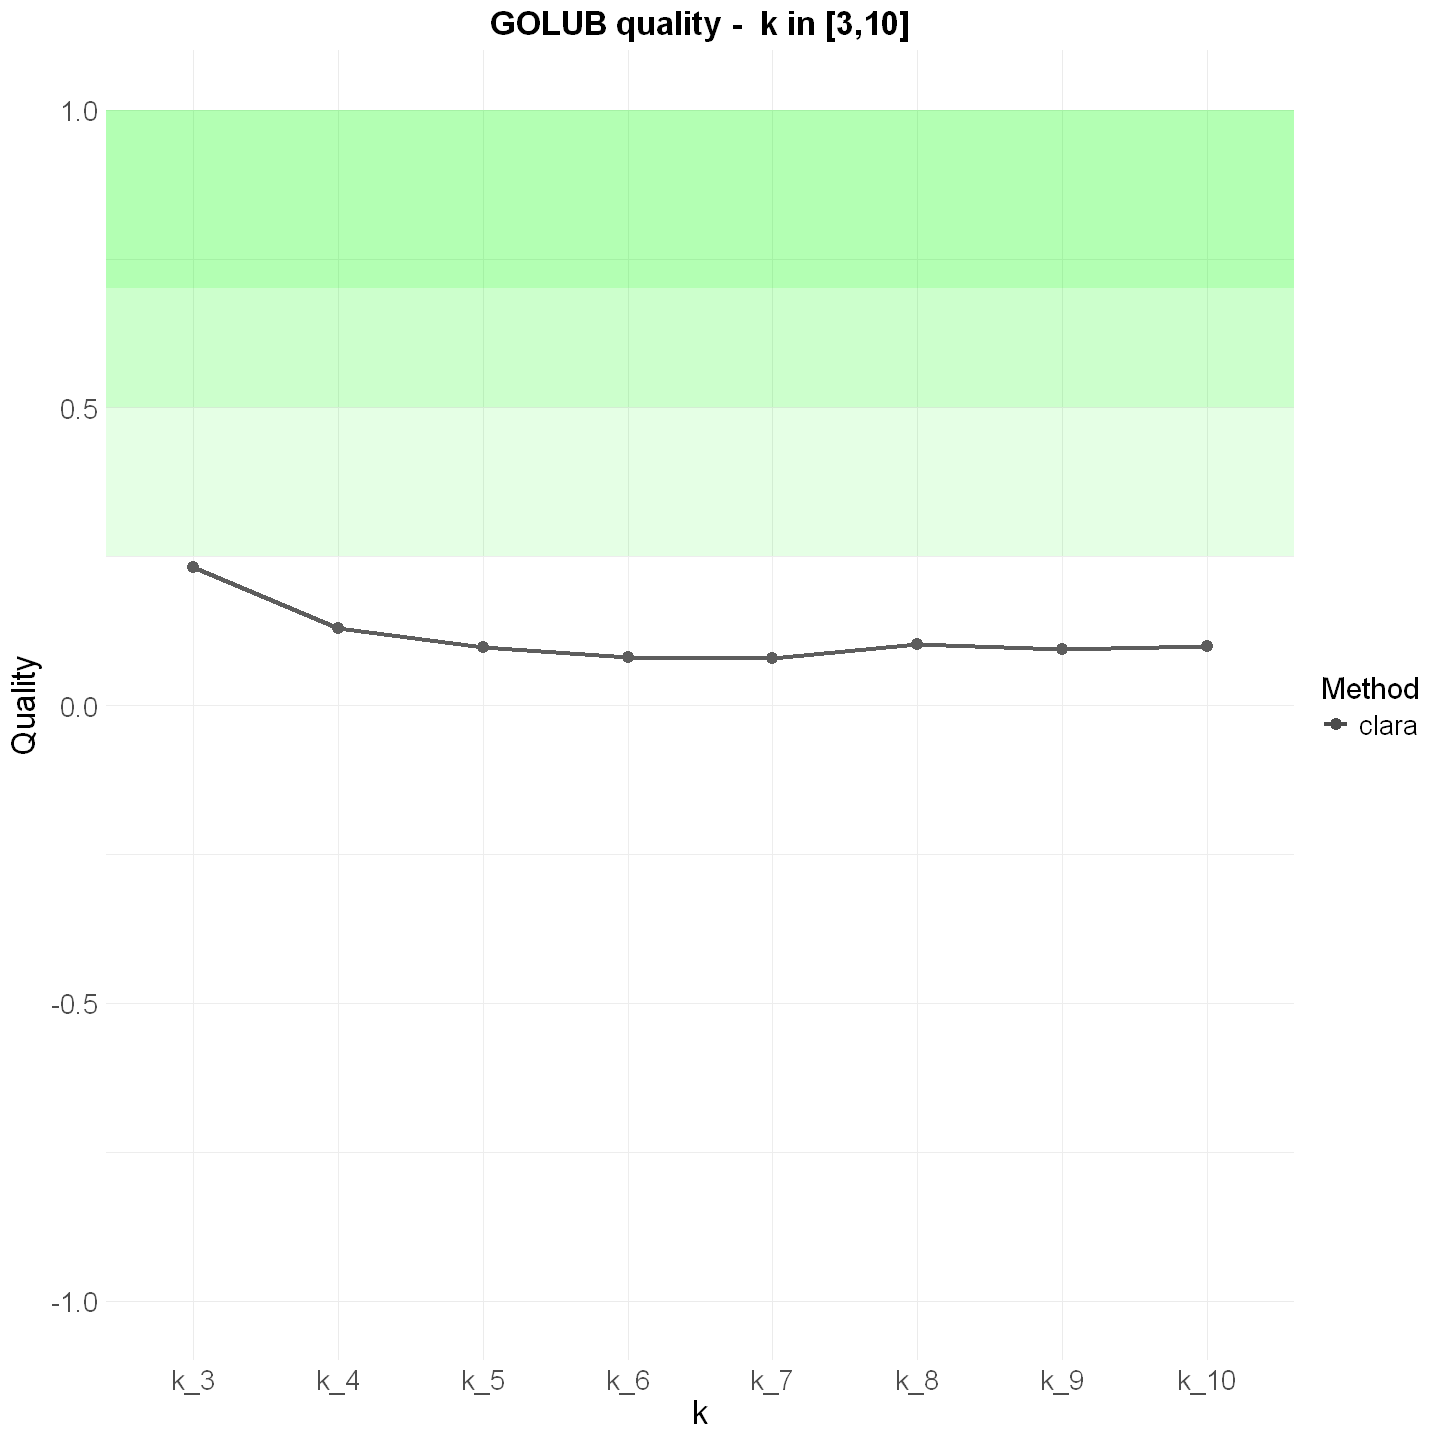

In [13]:
p <- ggplot(qual_melt, aes(x = variable, y = value, color = Method, group = Method)) +
     geom_point(size = 3) +
     geom_line(size = 1.2) +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('GOLUB quality -  k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Quality'
  ) +
  scale_y_continuous(limits = c(-1, 1)) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16)
  )

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.7, ymax = 1, alpha = 0.3, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.5, ymax = 0.7, alpha = 0.2, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.25, ymax = 0.5, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = -1, ymax = 0.25, alpha = 0.1, fill = "white")

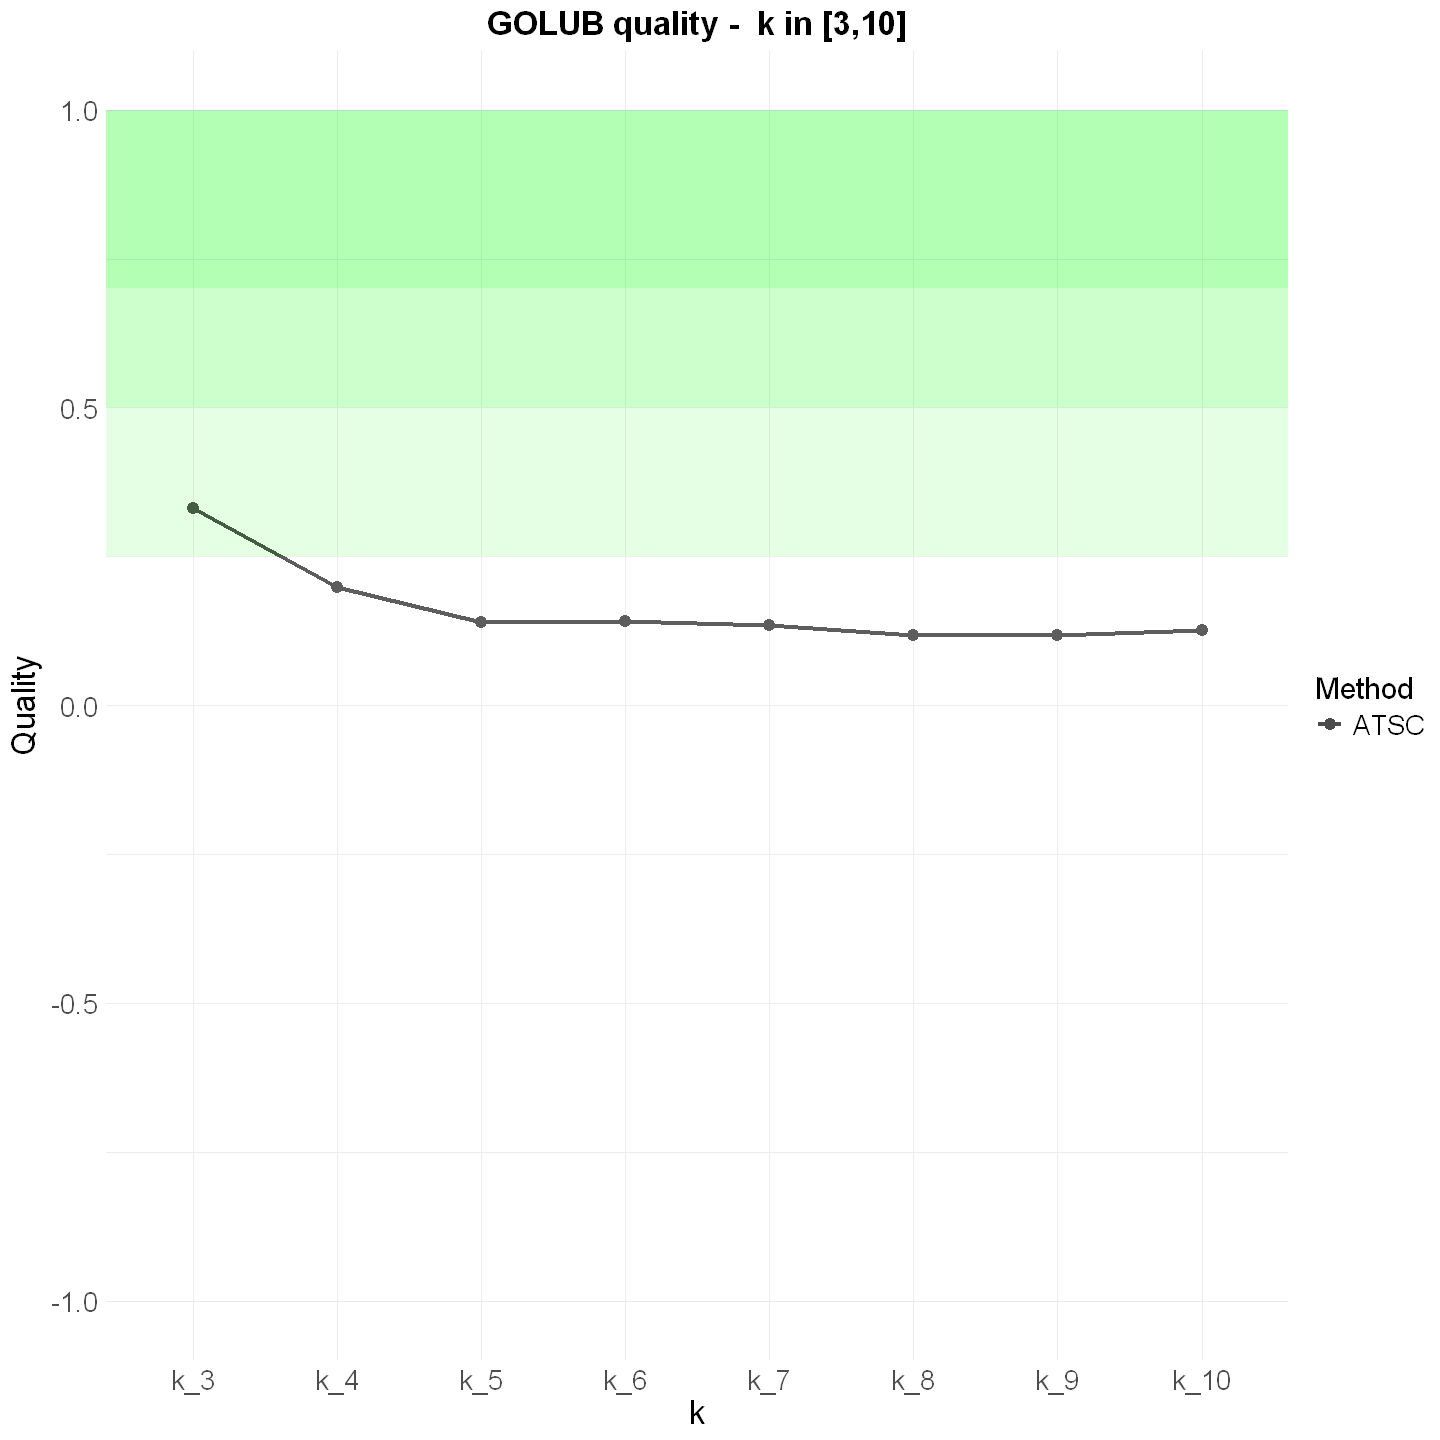

In [14]:
p <- ggplot(qual_ATSC_melt, aes(x = variable, y = value, color = Method, group = Method)) +
     geom_point(size = 3) +
     geom_line(size = 1.2) +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('GOLUB quality -  k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Quality'
  ) +
  scale_y_continuous(limits = c(-1, 1)) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16)
  )

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.7, ymax = 1, alpha = 0.3, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.5, ymax = 0.7, alpha = 0.2, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.25, ymax = 0.5, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = -1, ymax = 0.25, alpha = 0.1, fill = "white")

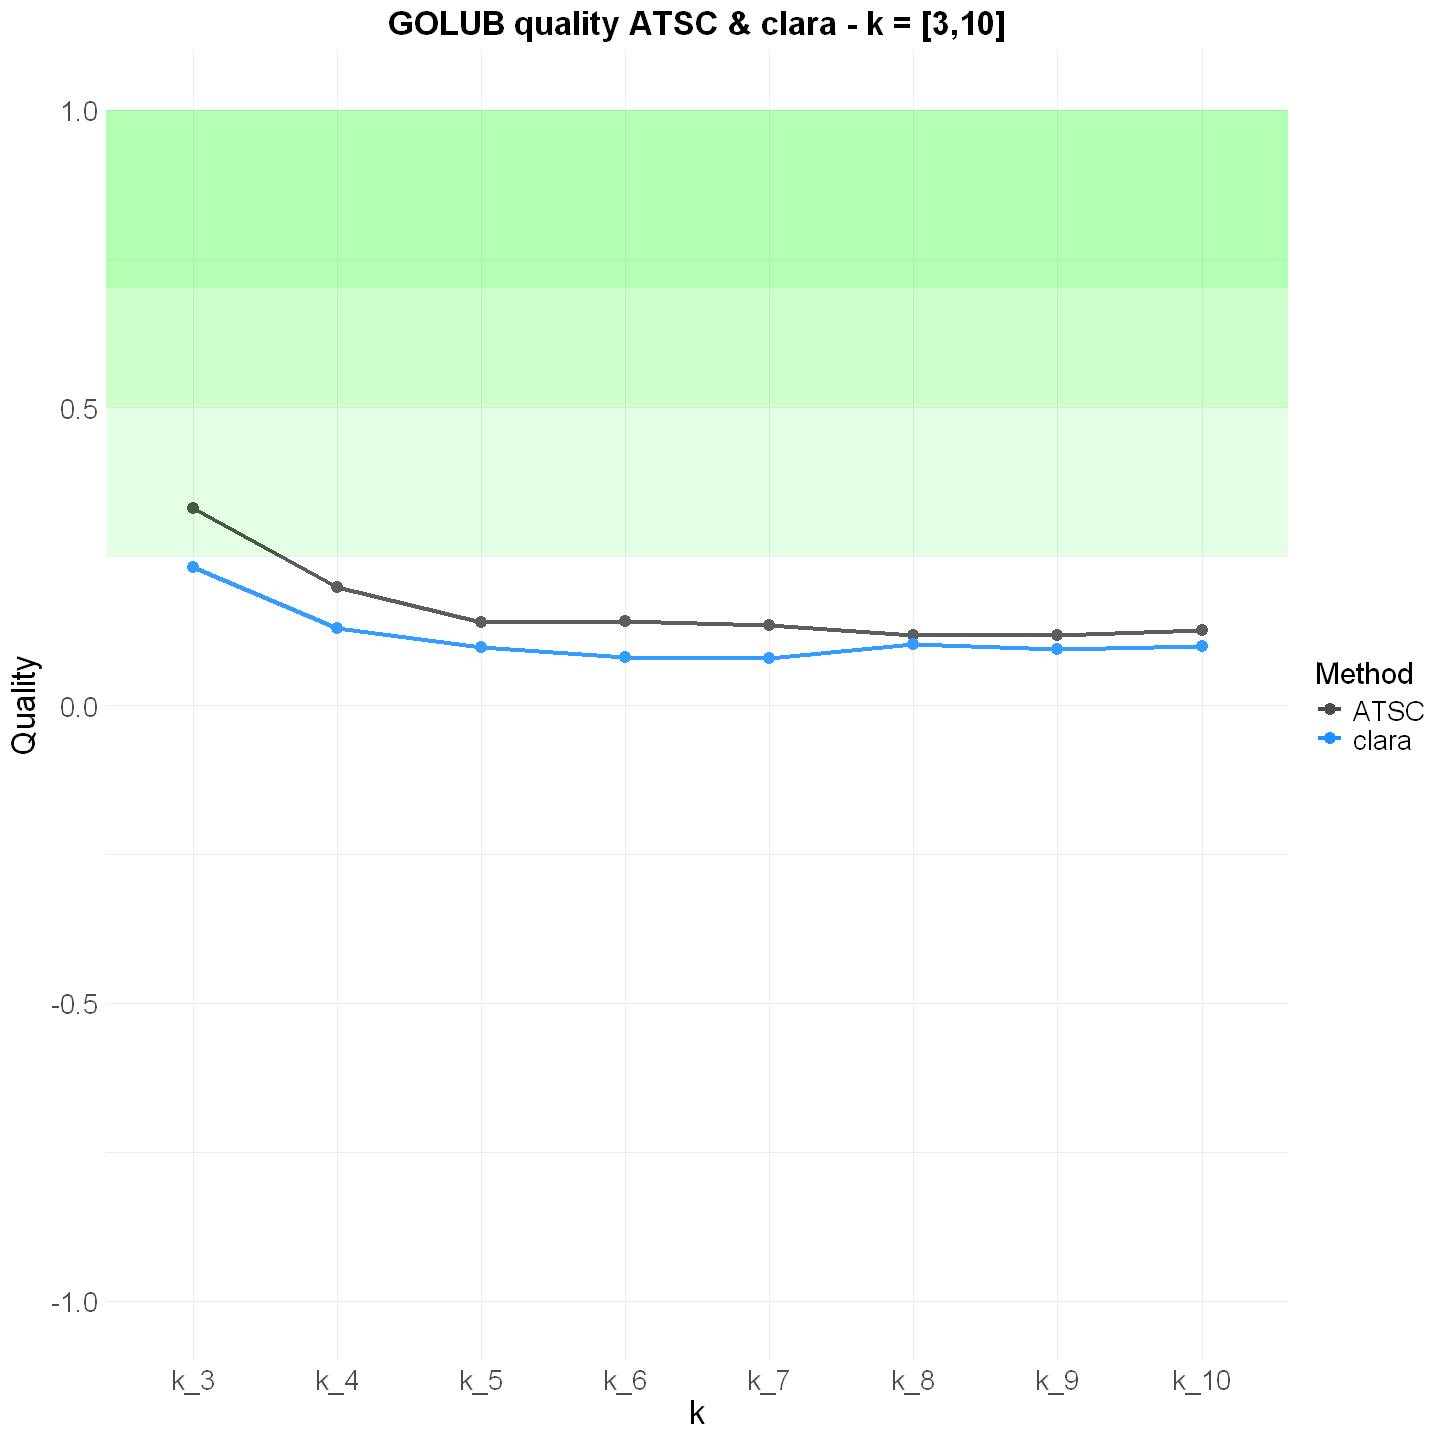

In [15]:
all_qual = rbind(qual_ATSC_melt, qual_melt)
p <- ggplot(all_qual, aes(x = variable, y = value, color = Method, group = Method)) +
     geom_point(size = 3) +
     geom_line(size = 1.2) +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('GOLUB quality ATSC & ', cbi, ' - k = [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Quality'
  ) +
  scale_y_continuous(limits = c(-1, 1)) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16)
  )

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.7, ymax = 1, alpha = 0.3, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.5, ymax = 0.7, alpha = 0.2, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.25, ymax = 0.5, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = -1, ymax = 0.25, alpha = 0.1, fill = "white")

Determining the optimal $k$ given the stabilities and qualities in `stab_range` and `qual_range` objects:

In [16]:
print(paste0("Stabilities and qualities per k with '", cbi, "' as clustering method"))
stab
qual
print(paste0("Stabily in k=", r_atsc$optimalK,": ", stab[paste0("k_",r_atsc$optimalK)]))
print(paste0("Quality in k=", r_atsc$optimalk,": ", qual[paste0("k_",r_atsc$optimalK)]))

[1] "Stabilities and qualities per k with 'clara' as clustering method"


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
stab_clara,0.9624413,0.8376369,0.7938185,0.7374804,0.728482,0.7120501,0.7050078,0.7030516,stab_clara,clara


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
qual_clara,0.2320141,0.1299018,0.09750963,0.08118129,0.07984548,0.1031934,0.09457494,0.09856581,qual_clara,clara


[1] "Stabily in k=3: 0.962441314553991"
[1] "Quality in k=: 0.23201412622582"


In [17]:
print(paste0("Stabilities and qualities per k with 'ATSC' as clustering method"))
stab_ATSC
qual_ATSC
print(paste0("Stabily in k=", r_atsc$optimalK_ATSC,": ", stab_ATSC[paste0("k_",r_atsc$optimalK_ATSC)]))
print(paste0("Quality in k=", r_atsc$optimalk_ATSC,": ", qual_ATSC[paste0("k_",r_atsc$optimalK_ATSC)]))

[1] "Stabilities and qualities per k with 'ATSC' as clustering method"


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
stab_ATSC,1,0.8727273,0.8208754,0.7885522,0.7683502,0.7508418,0.7131313,0.7050505,stab_ATSC,ATSC


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
qual_ATSC,0.330987,0.197985,0.1396322,0.140963,0.1339447,0.1182351,0.1177205,0.1264752,qual_ATSC,ATSC


[1] "Stabily in k=3: 1"
[1] "Quality in k=: 0.330987013515012"


# Clusters

In [18]:
# Internal method used to group individuals per cluster
individuals_per_cluster = function(qualityResult) {
    
  qual_df = as.data.frame(assay(qualityResult))
    

  cluster_pos_str = as.character(unlist(qual_df["Cluster_position"]))
  cluster_labels_str = as.character(unlist(qual_df["Cluster_labels"]))

  cluster_pos = as.list(strsplit(cluster_pos_str, ",")[[1]])
  cluster_labels = as.list(strsplit(cluster_labels_str, ",")[[1]])

  individuals_in_cluster = as.data.frame(cbind(cluster_labels, cluster_pos))
  colnames(individuals_in_cluster) = c("Individual", "Cluster")

  return(individuals_in_cluster)
}

In [19]:
dataset = r_atsc$trimmmedDataset
qual_range = qualityRange(data=dataset, k.range=k.range, 
                            all_metrics=TRUE, seed=seed,
                            cbi=cbi)
optimal_k = r_atsc$optimalK_ATSC
cluster_individuals = individuals_per_cluster(assay(qual_range[paste0("k_",optimal_k)]))
print(paste0("CBI: ", cbi, " - k: ", optimal_k))
for (cluster_i in 1:optimal_k) {
    ind_in_cluster = paste(unlist(cluster_individuals[cluster_individuals$Cluster == cluster_i, ]["Individual"]), collapse = ",")
    print(paste("Cluster", cluster_i, ":", ind_in_cluster))
    print("")
}



Data loaded.
Number of rows: 55
Number of columns: 89



Processing all metrics, 'merge', in dataframe (88)

	Calculation of k = 3

	Calculation of k = 4

	Calculation of k = 5

	Calculation of k = 6

	Calculation of k = 7

	Calculation of k = 8

	Calculation of k = 9

	Calculation of k = 10



[1] "CBI: clara - k: 3"
[1] "Cluster 1 : B1,B2,B3,B5,B7,B8,B9,B12,B13,B14,B15,B16,B18,B19,B20,B22,B23,B24,B25,B26,B28,B29,B30,B31,B33,B34,B35,B36,B37,B38"
[1] ""
[1] "Cluster 2 : T2,T3,T4,T5,T6,T7,T8"
[1] ""
[1] "Cluster 3 : AML1,AML3,AML7,AML8,AML9,AML11,AML12,AML13,AML14,AML15,AML16,AML17,AML18,AML19,AML21,AML23,AML24,AML25"
[1] ""


# PCA <a class="anchor" id="pca"></a>
We employ Principal Component Analysis (PCA) as a dimensionality reduction technique to facilitate the visualization of clusters within our dataset. PCA allow us to transform the original high-dimensional data into a lower-dimensional space, while preserving as much of the variability as possible.

In [20]:
dataset["Cluster"] = as.factor(as.numeric(cluster_individuals$Cluster))
if (pca_suitability$pca_suitable) {
    pca_df = dataset
} else {
    pca_matrix = dataset %>% select(-Cluster)
    r_pca = evaluomeR::performPCA(dataset = pca_matrix)
    pca_df = r_pca$dataset_ncp
    pca_df$Cluster <- as.factor(dataset$Cluster)
    pca_df$Description <- dataset$Description
}
head(pca_df)

Parameter 'npc' is null. Computing number of factors automatically:

Number of factors, 'ncp' used is: 15



,Description,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7,Dim.8,Dim.9,Dim.10,Dim.11,Dim.12,Dim.13,Dim.14,Dim.15,Cluster
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,B1,-5.3830152,1.037731,0.7503285,0.01223139,2.44701950,4.6954161,-0.95599145,-1.83654215,0.1207957,-0.1210186,0.7474705,-0.30419306,-0.2640921,2.47445238,0.2217406,1
3,T2,-1.8200060,-11.256867,0.7835707,0.81983314,0.28485088,-0.7488412,-0.30468224,-0.05071709,1.5728318,0.8884810,0.3035865,-0.13856162,1.2257006,-1.33098737,1.6255272,2
4,B2,-4.4213609,1.032211,-2.8337581,-4.32290243,1.08568002,-0.7285185,1.72912530,2.90189217,0.2174474,-0.1978109,-0.8645533,-0.08332903,1.5778251,0.09365132,-0.5719614,1
5,B3,-0.7942592,1.907912,0.8635516,-4.07290978,-0.61971964,0.7701509,1.16889989,1.72937961,1.4387271,0.5977240,-0.1877892,-1.17772390,0.6891134,0.84576518,-1.4544816,1
6,T3,-0.5312219,-10.700496,1.0748437,0.45562124,-0.06545797,-0.1236306,-1.23658847,1.14694262,1.1038355,-0.8650478,1.6793984,-0.26821438,-0.8232766,-0.47992839,0.1385123,2
8,B5,-5.1445530,1.208945,-2.8814505,3.44218348,3.37250694,0.6890204,-0.03496267,1.32042161,-1.0064977,-0.4207511,2.1332910,-0.09797498,2.2245641,0.75717531,-1.2083256,1


Warning message:
"The following aesthetics were dropped during statistical transformation: label.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?"
Warning message:
"ggrepel: 20 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


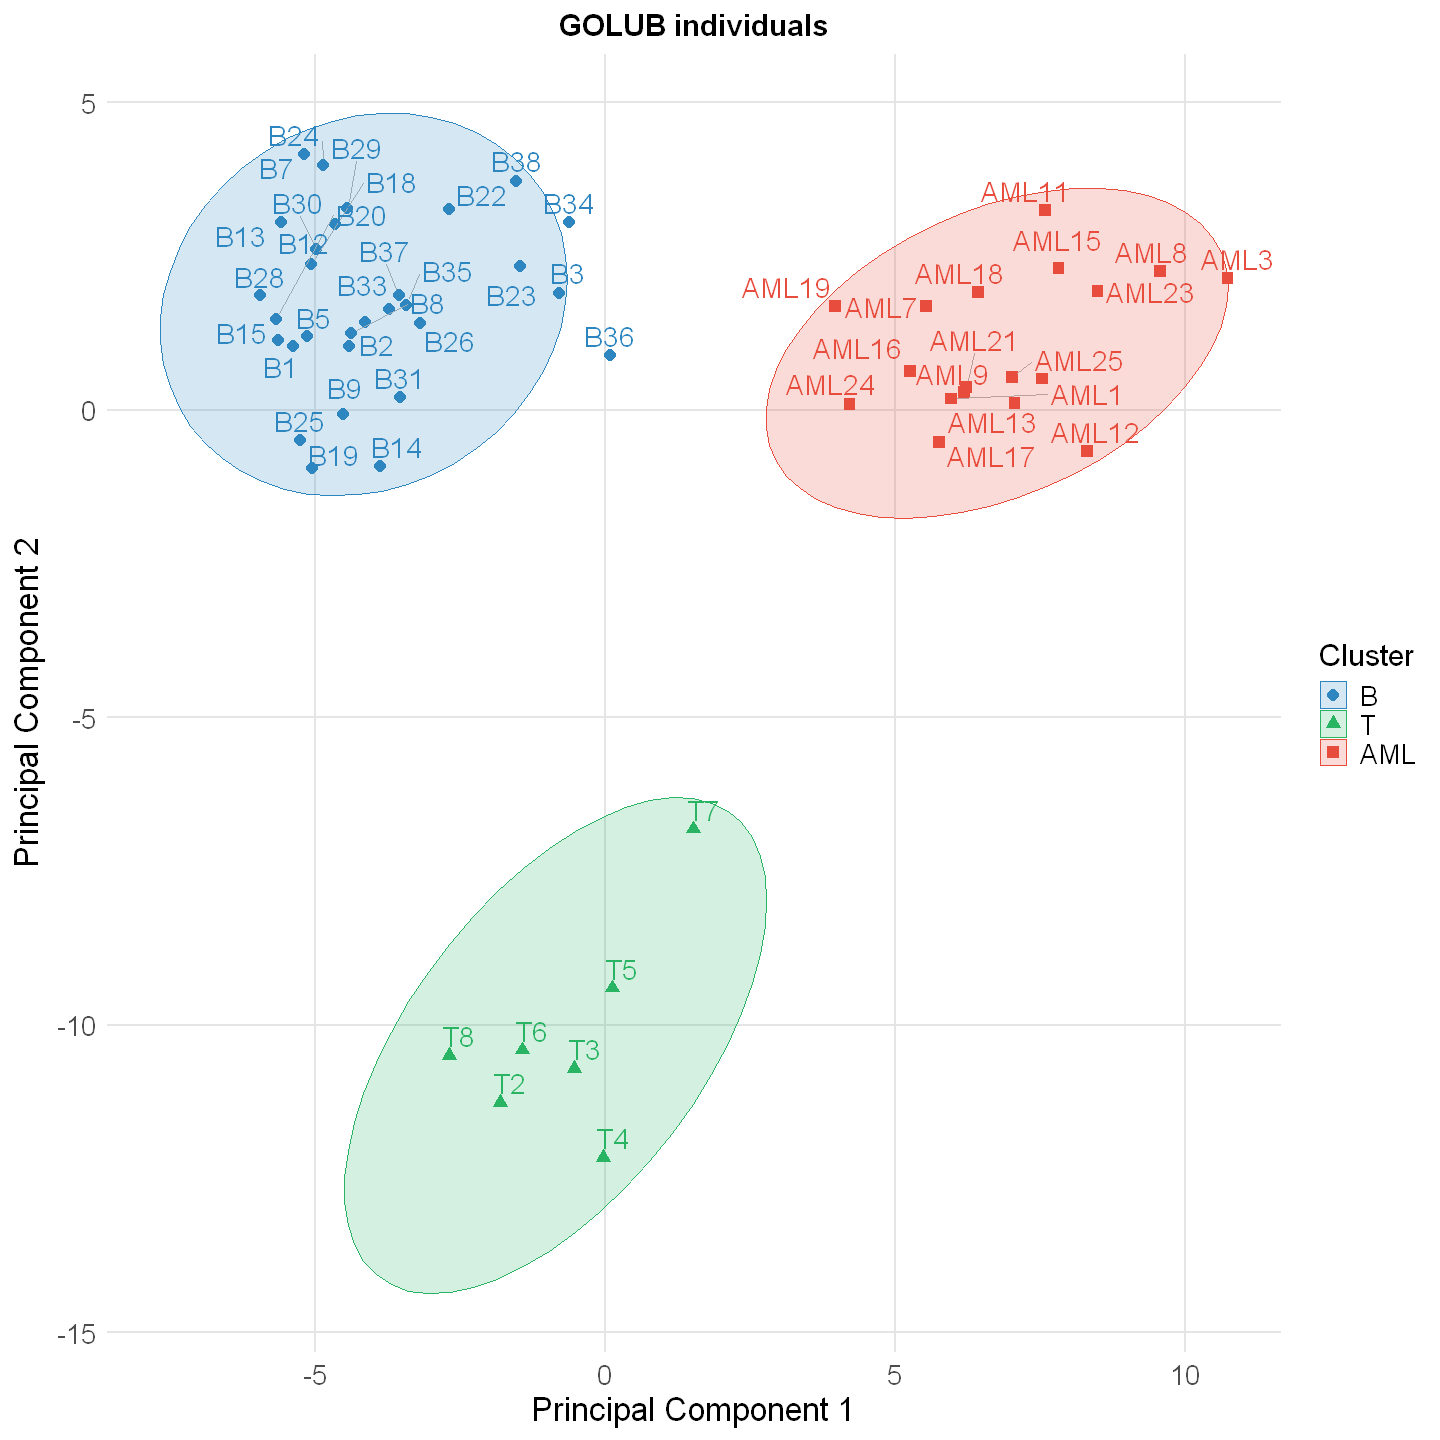

In [21]:
custom_colors = c("#2E86C1", "#28B463", "#E74C3C", "#9B59B6", "#F1C40F", "#7F8C8D")

cluster_shapes = c(16, 17, 15, 18, 19)
cluster_labels = c("B", "T", "AML")

ggplot(pca_df, aes(x = Dim.1, y = Dim.2, shape = Cluster, color = Cluster, label = Description)) +
  geom_point(size = 3) +
  geom_text_repel(
    vjust = 1,
    hjust = 1,
    size = 6,
    show.legend = FALSE,
    point.padding = 0.4,
    box.padding = 0.25,
    max.overlaps = 10,
    segment.color = "grey70",
    segment.size = 0.2
  ) +
  stat_ellipse(aes(fill = Cluster), level = 0.95, alpha = 0.2, geom = "polygon") +
  labs(
    title = "GOLUB individuals",
    x = "Principal Component 1",
    y = "Principal Component 2"
  ) +
  scale_shape_manual(values = cluster_shapes, labels = cluster_labels) +
  scale_color_manual(values = custom_colors, labels = cluster_labels)  +
  scale_fill_manual(values = custom_colors, labels = cluster_labels)   +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank()
  )


# Sensitivity <a class="anchor" id="sensitivity"></a>

In this Section we evaluate the sensitivity of our clustering using the `MLmetrics::Sensitivity` method. Sensitivity, or the true positive rate, measures the ability to correctly identify positive instances within the data. By focusing on sensitivity, we aim to ensure that our model effectively captures the relevant clusters, minimizing the number of false negatives. 

In [22]:
if (length(r_atsc$trimmedRows) > 0) {
    dataset["Class"] = as.data.frame(golub)["Class"][-r_atsc$trimmedRows, ]
} else {
    dataset["Class"] = as.data.frame(golub)["Class"]
}

In [23]:
dataset["Class_n"] = gold_standard_vector
# Table of prediction vs actual classification
head(dataset[, c("Description", "Class", "Class_n")])

,Description,Class,Class_n
,<fct>,<fct>,<dbl>
1,B1,B,1
3,T2,T,2
4,B2,B,1
5,B3,B,1
6,T3,T,2
8,B5,B,1


In [24]:
# Getting a vector of prediction vs actual classification
#actual = as.factor(as.vector(unlist(dataset["Class_n"])))
predicted <- factor(as.vector(unlist(dataset["Cluster"])))

print("gold standard")
gold_standard_vector
print("predicted")
predicted

[1] "gold standard"


[1] 1 2 1 1 2 1 2 2 2 1 2 1 1 1 1 1 1 2 1 1 1 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3

[1] "predicted"


[1] 1 2 1 1 2 1 2 2 2 1 2 1 1 1 1 1 1 2 1 1 1 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3
Levels: 1 2 3

In [25]:
sens = MLmetrics::Sensitivity(y_pred = predicted, y_true = gold_standard_vector)
sens = format(round(sens*100, 2), nsmall = 2)
print(paste0("Sensitivity: ", sens, "%"))

[1] "Sensitivity: 100.00%"


# CER <a class="anchor" id="cer"></a>
To assess the overall accuracy of our clustering, we compute the Classification Error Rate (CER) and compare it with the gold standard classification. CER represents the proportion of misclassified instances, thus providing a clear measure of the clustering performance in assigning individuals to the correct clusters.

In [26]:
cer = CER(predicted, gold_standard_vector)
cer = format(round(cer*100, 2), nsmall = 2)
print(paste0("CER: ", cer, "%"))

[1] "CER: 0.00%"
